In [15]:
import glob
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import Audio, display
from praatio import textgrid

import findsylls  # This module should contain your segment_audio function


In [8]:
# --- Step 1. Choose a Random Audio File ---
# Use globbing to find all FLAC files in the LibriSpeech train-clean-100 directory.
audio_file_pattern = "data/LibriSpeech/train-clean-100/**/*.flac"
audio_files = glob.glob(audio_file_pattern, recursive=True)

if not audio_files:
    raise FileNotFoundError("No audio files found in the specified directory.")

# Select a random audio file each time the script is run.
audio_path = random.choice(audio_files)
print(f"Selected audio file: {audio_path}")


Selected audio file: data/LibriSpeech/train-clean-100/3830/12530/3830-12530-0037.flac


In [9]:
# --- Step 2. Load Audio and Perform Segmentation ---
# Load the raw audio using librosa (using a desired sample rate, e.g., 16 kHz).
y, sr = librosa.load(audio_path, sr=16000)
time_audio = np.arange(len(y)) / sr

# Call your segmentation function (from findsylls.py).
# It should return:
#   syllables: a list of triplets (valley_start, peak, valley_end) in sample indices,
#   t: an adjusted time vector corresponding to the amplitude envelope,
#   env: the computed amplitude envelope.
syllables, t, env = findsylls.segment_audio(audio_path)


0.056 0.11599999999999999 0.05999999999999999
0.11599999999999999 0.546 0.43000000000000005
0.546 0.716 0.16999999999999993
0.716 0.836 0.12
0.836 0.926 0.09000000000000008
0.926 1.056 0.13
1.056 1.296 0.24
1.296 1.506 0.20999999999999996
1.506 1.676 0.16999999999999993
1.676 1.766 0.09000000000000008
1.766 1.846 0.08000000000000007
1.846 2.006 0.1599999999999997
2.006 2.266 0.26000000000000023
2.266 2.416 0.1499999999999999
2.416 2.536 0.1200000000000001
2.536 2.746 0.20999999999999996
2.746 2.846 0.10000000000000009
2.846 3.056 0.20999999999999996
3.056 3.306 0.25
3.306 3.526 0.21999999999999975
3.526 3.616 0.0900000000000003
3.616 3.7560000000000002 0.14000000000000012
3.7560000000000002 3.926 0.16999999999999993
3.926 4.046 0.1200000000000001
4.046 4.306 0.2599999999999998
4.306 4.486 0.17999999999999972
4.486 4.726 0.2400000000000002
4.726 4.816 0.08999999999999986
4.816 5.016 0.20000000000000018
5.016 5.206 0.1900000000000004
5.206 5.326 0.11999999999999922
5.326 5.506 0.18000000

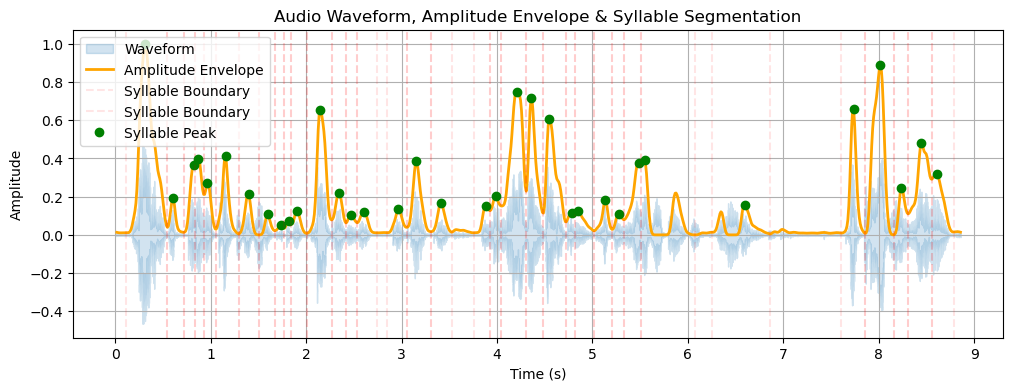

In [10]:
# --- Step 3. Plot the Waveform, Amplitude Envelope, and Segmentation ---
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw waveform.
librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.2, label="Waveform")

# Plot the amplitude envelope computed by your segmentation code.
ax.plot(t, env, color='orange', linewidth=2, label="Amplitude Envelope")

# For each syllable triplet, plot the boundaries and the peak.
for idx, (valley_start, peak, valley_end) in enumerate(syllables):
    # Convert sample indices to seconds.
    valley_start_time = valley_start
    peak_time = peak 
    valley_end_time = valley_end
    
    # Plot vertical dashed lines for valley points (i.e., syllable boundaries).
    ax.axvline(x=valley_start_time, color='red', linestyle='--', alpha=0.1,
               label="Syllable Boundary" if idx == 0 else None)
    ax.axvline(x=valley_end_time, color='red', linestyle='--', alpha=0.1,
               label="Syllable Boundary" if idx == 0 else None)
    # Mark the peak with a green dot.
    # Use np.searchsorted to get the envelope value near the peak time.
    env_index = np.searchsorted(t, peak_time)
    env_value = env[env_index] if env_index < len(env) else env[-1]
    ax.plot(peak_time, env_value, 'go', label="Syllable Peak" if idx == 0 else None)

ax.set_title("Audio Waveform, Amplitude Envelope & Syllable Segmentation")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()
plt.grid(True)
plt.show()


In [5]:
# --- Step 4. Add Interactive Playback Position ---
# Draw a vertical blue line that will serve as a time cursor.
current_line = ax.axvline(x=0.0, color='blue', linewidth=2, label="Current Position")
fig.canvas.draw()

# Create an interactive slider to update the current position.
time_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=time_audio[-1],
    step=0.01,
    description='Time (s):',
    continuous_update=True,
    readout_format='.2f'
)

def update_line(change):
    """Update the vertical line position on the plot."""
    current_time = change['new']
    # Set xdata to a sequence (two identical points) instead of a single float.
    current_line.set_xdata([current_time, current_time])
    fig.canvas.draw_idle()

time_slider.observe(update_line, names='value')
display(time_slider)


FloatSlider(value=0.0, description='Time (s):', max=13.6049375, step=0.01)

In [6]:
# --- Step 5. Display the Audio Player ---
display(Audio(y, rate=sr))


In [11]:
audio_path

'data/LibriSpeech/train-clean-100/3830/12530/3830-12530-0037.flac'

In [25]:
def plot_syllables_with_textgrid(wav_path: str,
                                 textgrid_path: str,
                                 sr: int = 16000,
                                 tier_name: str = 'speaker : syllables'):
    """
    Plot waveform, overlay predicted syllable segments (findsylls),
    and TextGrid annotations (with labels).

    Args:
      wav_path: path to .wav/.flac audio file
      textgrid_path: path to .TextGrid file
      sr: sampling rate for loading audio
      tier_name: name of the syllable tier in the TextGrid
    """
    # 1) load audio
    y, _ = librosa.load(wav_path, sr=sr)
    times = np.arange(len(y)) / sr

    # 2) get predicted syllables
    syllables, t_env, env = findsylls.segment_waveform(y, sr)

    # 3) parse TextGrid tier
    tg = textgrid.openTextgrid(textgrid_path, includeEmptyIntervals=True)
    tier = tg.getTier(tier_name)
    gt_sylls = [(start, end, label) for start, end, label in tier.entries if label.strip()]
    # 4) plotting
    fig, ax = plt.subplots(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.2, label="Waveform")
    ax.plot(t_env, env, color='orange', linewidth=2, label="Amplitude Envelope")

    # 4) Predicted boundaries & peaks (vertical, lightly)
    for idx, (v_start, v_peak, v_end) in enumerate(syllables):
        ax.axvline(v_start, color='red', linestyle='--', alpha=0.3,
                   label="Predicted Boundary" if idx == 0 else None)
        ax.axvline(v_end, color='red', linestyle='--', alpha=0.3, label=None)
        env_idx = np.searchsorted(t_env, v_peak)
        env_val = env[env_idx] if env_idx < len(env) else env[-1]
        ax.plot(v_peak, env_val, 'go',
                label="Predicted Peak" if idx == 0 else None)

    # 5) GT as horizontal bar at bottom
    ymin, ymax = ax.get_ylim()
    bar_height = 0.03 * (ymax - ymin)
    bar_y = ymin
    intervals = [(start, end - start) for start, end, _ in gt_sylls]
    ax.broken_barh(intervals, (bar_y, bar_height),
                   facecolors='blue', alpha=0.5, label="GT Syllables")

    # 6) Optional: annotate GT labels above the bar
    for start, end, label in gt_sylls:
        mid = (start + end) / 2
        ax.text(mid, bar_y + bar_height + 0.01 * (ymax - ymin), label,
                rotation=90, va='bottom', ha='center',
                color='blue', fontsize=8)

    # Final touches
    ax.set_title("Audio Waveform, Envelope & Syllable Segmentation\n(GT as Bottom Bar)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


0.07600000000000001 0.196 0.12
0.196 0.436 0.24
0.436 0.606 0.16999999999999998
0.606 0.716 0.10999999999999999
0.716 0.896 0.18000000000000005
0.896 1.006 0.10999999999999999
1.006 1.106 0.10000000000000009
1.106 1.296 0.18999999999999995
1.296 1.456 0.15999999999999992
1.456 1.776 0.32000000000000006
1.776 1.946 0.16999999999999993
1.946 2.166 0.21999999999999997
2.166 2.426 0.26000000000000023
2.426 2.706 0.2799999999999998
2.706 2.826 0.1200000000000001
2.826 2.946 0.1200000000000001
2.946 3.146 0.19999999999999973
3.146 3.286 0.14000000000000012
3.286 3.436 0.1499999999999999
3.436 3.546 0.10999999999999988
3.546 3.796 0.25
3.796 3.996 0.20000000000000018
3.996 4.146 0.1499999999999999
4.146 4.286 0.13999999999999968
4.286 4.476 0.1900000000000004
4.476 4.706 0.23000000000000043
4.706 4.876 0.16999999999999993
4.876 5.086 0.20999999999999996
5.086 5.226 0.13999999999999968
5.226 5.426 0.20000000000000018
5.426 5.446 0.019999999999999574
Skipping segment due to short duration: 0.02

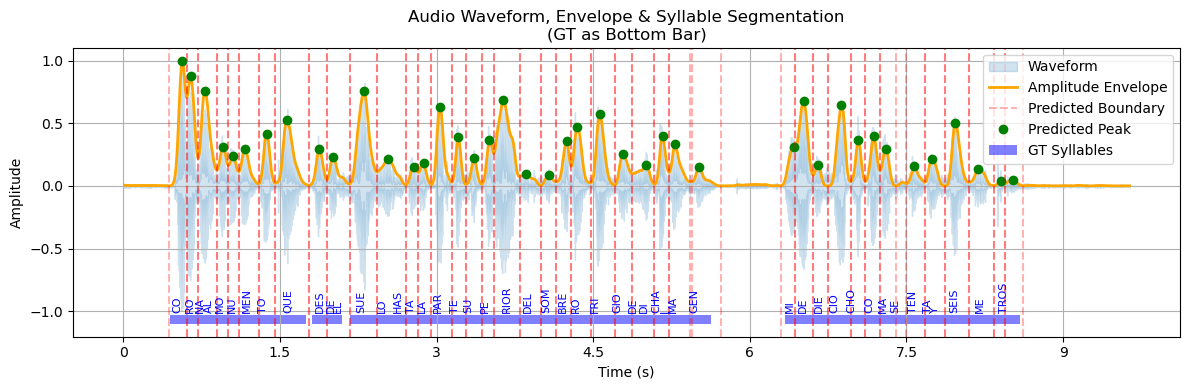

In [26]:
wikispanish_tg_path = "data/WikiSpanish_sample/WKSP_M_0064_E1_0009_aligned.TextGrid"
wikispanish_wav_path = "data/WikiSpanish_sample/WKSP_M_0064_E1_0009.flac"
plot_syllables_with_textgrid(wikispanish_wav_path,
                             wikispanish_tg_path,
                             sr=16000,
                             tier_name='speaker : syllables')